## BECS 2 Data Challenge: Predicting Cancer Status of Patients
Koch Kilian (ZHAW), Rieder Jonathan (ZHAW), Yar Kevin (ZHAW)

The aim of this project work is to predict 6 different healt status of patients (healthy, breast-, lung-, pancreatic-, colorectal- and prostate cancer). The prediction is based on mass spectroscopy data of different protein levels meassured in patients blood. Detecting cancer based on so called biomarkers is a current field of research. Related publications are linked bellow:

https://ascopubs.org/doi/10.1200/JCO.19.02768?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed

https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/pmic.201600240

https://www.sciencedirect.com/science/article/pii/S0092867420308746?via%3Dihub

Note: There are joblib-commands in the script which we commented out - use them if you run the model multiple times

## Part 1: Loading packages and define initial Parameters

In [1]:
#import necessary packages 
import os
import random
import xgboost
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import dash_bio
import eli5
from sklearn.tree import export_graphviz
from subprocess import call
from math import log2, log10
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn_genetic import GAFeatureSelectionCV                    # you need version 0.8.0 for max_features, can only be intalled with pip

## Part 2: Data Preprocessing
In this section the raw data is visualised, preprocessed and checked

In [2]:
#create pandas dataframe
path = "./RawData/tidy.csv"
pathMet = "./RawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

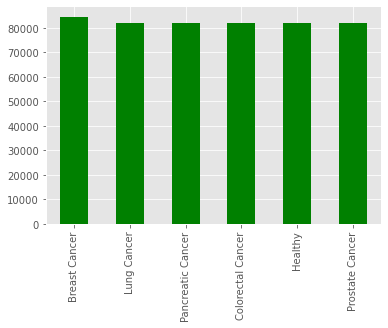

In [3]:
#remove samples which are not in the metadata index column (quality control etc)
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]
tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")
tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]
tidySub.Cancer.value_counts().plot(kind='bar', color='green');

We clearly have a balanced dataset - all classes have approximately the same number of samples

In [4]:
tidySub.head()

,R.FileName,uniprot,meanAbu,Cancer
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6H9,11601.398438,Lung Cancer
1,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I0,3827.466797,Lung Cancer
2,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I1,114115.796875,Lung Cancer
3,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I7,4293.524902,Lung Cancer
4,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6J1,5969.785645,Lung Cancer


In [5]:
#store data in list for each type of protein and cancer
ValueDF = tidySub.groupby(['uniprot','Cancer'])['meanAbu'].apply(list)
ValueDF = ValueDF.reset_index()
ValueDF.head()

,uniprot,Cancer,meanAbu
0,A0A075B6H9,Breast Cancer,"[35277.67578125, 34095.4765625, 3512.60546875,..."
1,A0A075B6H9,Colorectal Cancer,"[38555.5703125, 37487.71875, 28599.8984375, 42..."
2,A0A075B6H9,Healthy,"[168020.15625, 9181.5859375, 5460.25927734375,..."
3,A0A075B6H9,Lung Cancer,"[11601.3984375, 4950.046875, 4343.33154296875,..."
4,A0A075B6H9,Pancreatic Cancer,"[14946.3359375, 4416.61767578125, 30662.833984..."


In [6]:
# For the log2 values, we use MeanDF which contains the meanAbu of all samples for each protein and cancer type
MeanDF = tidySub.groupby(['uniprot','Cancer'])['meanAbu'].mean()
MeanDF = pd.DataFrame(MeanDF)
MeanDF = MeanDF.reset_index()

In [7]:
# each protein has a mean abu for each cancer type
MeanDF[MeanDF.uniprot == 'A0A075B6H9']

,uniprot,Cancer,meanAbu
0,A0A075B6H9,Breast Cancer,13187.140263
1,A0A075B6H9,Colorectal Cancer,11832.107357
2,A0A075B6H9,Healthy,39325.718099
3,A0A075B6H9,Lung Cancer,19166.234025
4,A0A075B6H9,Pancreatic Cancer,30563.667741
5,A0A075B6H9,Prostate Cancer,12818.901481


In [8]:
# now, we create a pivoted view that has cancer types as columns
pivMeanDF = MeanDF.pivot_table(values='meanAbu', index=['uniprot'], columns='Cancer')
pivMeanDF = pivMeanDF.reset_index()
pivMeanDF

Cancer,uniprot,Breast Cancer,Colorectal Cancer,Healthy,Lung Cancer,Pancreatic Cancer,Prostate Cancer
0,A0A075B6H9,1.318714e+04,1.183211e+04,3.932572e+04,1.916623e+04,3.056367e+04,1.281890e+04
1,A0A075B6I0,3.631717e+04,4.091292e+04,1.762420e+05,2.695806e+04,4.795375e+04,3.296956e+04
2,A0A075B6I1,7.822352e+03,9.022135e+03,1.490596e+04,1.153265e+04,1.936417e+04,7.794840e+03
3,A0A075B6I7,4.667722e+03,4.476476e+03,7.371171e+03,4.608651e+03,4.906442e+03,5.239455e+03
4,A0A075B6J1,4.698463e+03,4.946763e+03,1.183982e+04,4.522844e+03,4.827412e+03,4.552161e+03
...,...,...,...,...,...,...,...
2725,Q9Y6L6,4.778257e+03,4.403394e+03,5.230566e+03,4.800621e+03,6.226449e+03,4.530669e+03
2726,Q9Y6N7,2.217552e+04,1.983380e+04,2.968121e+04,1.977552e+04,2.108111e+04,1.959120e+04
2727,Q9Y6R7,5.230733e+06,4.153629e+06,4.056345e+06,3.988329e+06,6.262894e+06,4.160906e+06
2728,Q9Y6Y9,1.095217e+04,1.229225e+04,1.094369e+04,1.151679e+04,1.290667e+04,9.403463e+03


In [9]:
#Create dictionary and process all data in the dataframes, keys are cancer types with corresponding dataframe as value
d = {}
for items in pivMeanDF.columns[1:]:
    if items == 'Healthy': # we don't calculate the change from healthy to healthy because there is none
        next
    else:
        print(items)
        name = (str(items.replace(" ", "")).lower())
        d[name] = pd.DataFrame(pivMeanDF[['uniprot', items, 'Healthy']])
        
        d[name] = d[name].set_index('uniprot')
        
        for protein in d[name].index:
        
            x = ValueDF[(ValueDF.uniprot == protein) & (ValueDF.Cancer == items)].meanAbu.values[0]
            y = ValueDF[(ValueDF.uniprot == protein) & (ValueDF.Cancer == 'Healthy')].meanAbu.values[0]
            d[name].at[protein, 'pvalue']  = stats.ttest_ind(x, y).pvalue
            d[name].pvalue.apply((log10))
            d[name].pvalue.multiply(-1)
            
            d[name]['L2F'] = np.log2(d[name][items] / d[name]['Healthy'])

Breast Cancer
Colorectal Cancer
Lung Cancer
Pancreatic Cancer
Prostate Cancer


#### Every **dataframe** contains:
* uniprot           = the uniprot identifier
* CancerX / Healthy = mean konzentration of the cancer and healthy sample
* p-value           = The p-value from a one-sided t-test comparing cancerX and healthy
* L2F               = The log2 of the ratio konzentration ratio $ L2F = log_{2}(\frac{Protein_{Cancer}}{Protein_{Healthy}}) $

In [10]:
print(d.keys())
d["prostatecancer"].head()

dict_keys(['breastcancer', 'colorectalcancer', 'lungcancer', 'pancreaticcancer', 'prostatecancer'])


Cancer,Prostate Cancer,Healthy,pvalue,L2F
uniprot,,,,
A0A075B6H9,12818.901481,39325.718099,0.020566,-1.617200
A0A075B6I0,32969.559180,176242.021566,0.003763,-2.418351
A0A075B6I1,7794.839966,14905.960042,0.050754,-0.935298
A0A075B6I7,5239.454541,7371.170549,0.378721,-0.492477
A0A075B6J1,4552.160962,11839.818555,0.037444,-1.379023


In [11]:
#joblib.dump(d, 'volcanoplot_data')

#### Set the parameter for the vulcano plot 
#### points of interest are proteins with;
* p-value < 0.05 
* Fold Change >= 2

In [12]:
i=''
params = dict(
    template = "ggplot2",
    effect_size='L2F',
    p='pvalue',
    snp = 'uniprot',
    gene=None,
    logp=True,
    title="Vulcanoplot " + i,
    xlabel="log2( Fold Change )",
    effect_size_line_width=np.log2(2),
    effect_size_line_color='#AB63FA',

    genomewideline_value=-np.log10(0.05), #p-value treshhold = 0.05
    genomewideline_width=2,
    genomewideline_color='#EF553B',

    highlight_color='#119DFF',
    col='#2A3F5F',
    autosize=False
)

In [14]:
i = "breastcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [15]:
i = "colorectalcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [16]:
i = "lungcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [17]:
i = "pancreaticcancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

In [14]:
i = "prostatecancer"
dash_bio.VolcanoPlot(dataframe=d[i].reset_index(), **params)

#### To only use the proteins of interest we filter the uniprot ID for part3: Data Preparation

In [16]:
protSel = []
for cancer in ["breastcancer", "colorectalcancer","lungcancer", "pancreaticcancer", "prostatecancer"]:
    #extract dataframe
    df = d[cancer]
    protSel.append(df[ (df.pvalue <= 0.05) & (df.L2F >= 2.0) | (df.L2F <= -2.0)].index.tolist())

protSel = list ( set ( np.concatenate(protSel) ) )    #remove duplicates

## Part 3: Data Preparation
In this section the raw data is prepared and reshaped to be fed into the different models. 
Additionaly the distribution of the input data is visualized to check if the data set is balanced. 
The data is converted into two main variables X (patiens and the coresponding protein quantities) and y (patients and the coresponding healt condition). 
Furthermore the data will be filtered to reduce noise. Moreover, further adjustments will be conducted to make the data suitable for model inputs.

### Data filtering

The following scatterplot shows **all the proteins** for each sample (different color) ranked by their concentration. 

The dataset shows a high range of protein concentration. From 75 to 580'412'224 A
 It is known in literature that biomarker measurements appear in the medium and low concentration range. 

In [17]:
#rank proteins by concentration
tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)
tidySub.head()

,R.FileName,uniprot,meanAbu,Cancer,Rank
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6H9,11601.398438,Lung Cancer,1090.0
1,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I0,3827.466797,Lung Cancer,2497.0
2,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I1,114115.796875,Lung Cancer,468.0
3,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I7,4293.524902,Lung Cancer,2325.0
4,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6J1,5969.785645,Lung Cancer,1538.0


Minimal meanAbu:  75.6575622558594 
Maximal meanAbu:  580412224.0


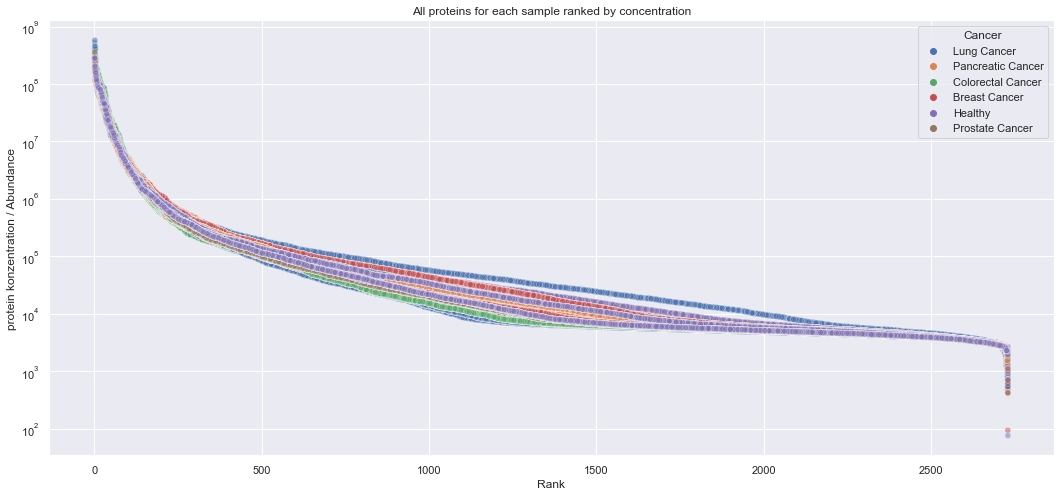

In [21]:
# With all proteins
print('Minimal meanAbu: ', tidySub.meanAbu.min(), '\nMaximal meanAbu: ',tidySub.meanAbu.max())
sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySub, alpha=0.5)
_.set_yscale("log")
_.set_title("All proteins for each sample ranked by concentration")
_.set_ylabel("protein konzentration / Abundance")


#### Comparison to Part 2

To compare the concentration range of all proteins with the proteins of interest (part 2) the following plot shows only the later.

As we can see the conzentration range now is from 2085 to 202'819'960 A. 
We use this range of the proteins of interest to make a cutoff with the whole data with:
* from 2500 to 150'000'000 A 
The reason not to use proteins from the head and tail are due to the sample preparation workflow which includes an depletion step. This leaves protein artefacts at the beginning
and end of the ranking.  

Minimal meanAbu:  2085.16528320313 
Maximal meanAbu:  202918960.0


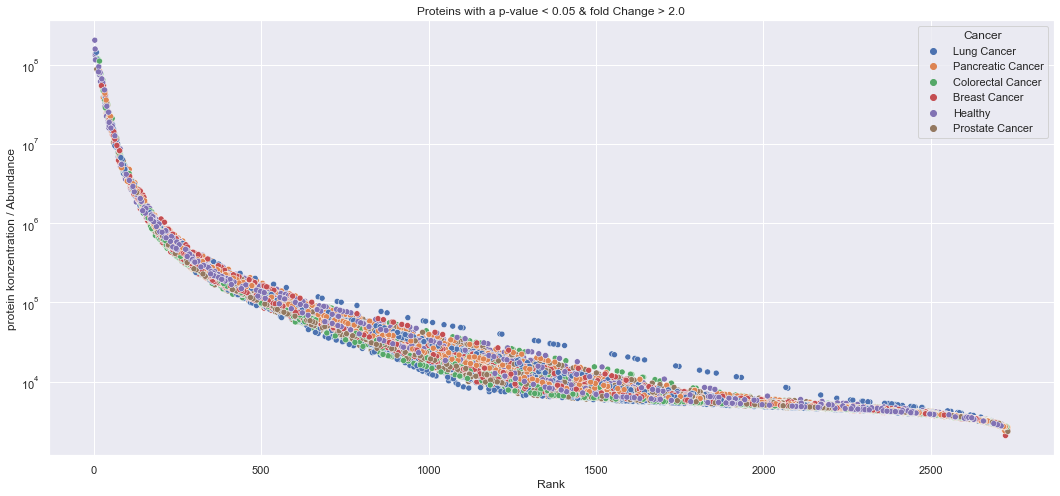

In [24]:
# With the selected proteins only
print('Minimal meanAbu: ',
      tidySub[ tidySub.uniprot.isin(protSel) ].meanAbu.min(),
      '\nMaximal meanAbu: ',
      tidySub[ tidySub.uniprot.isin(protSel) ].meanAbu.max())

sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySub[ tidySub.uniprot.isin(protSel) ])
_.set_yscale("log")
_.set_title("Proteins with a p-value < 0.05 & fold Change > 2.0")
_.set_ylabel("protein konzentration / Abundance");

In [25]:
# With proteins in the range
tidySubFiltered = tidySub[ (tidySub.meanAbu <= 150000000) & (tidySub.meanAbu >=2500) ]

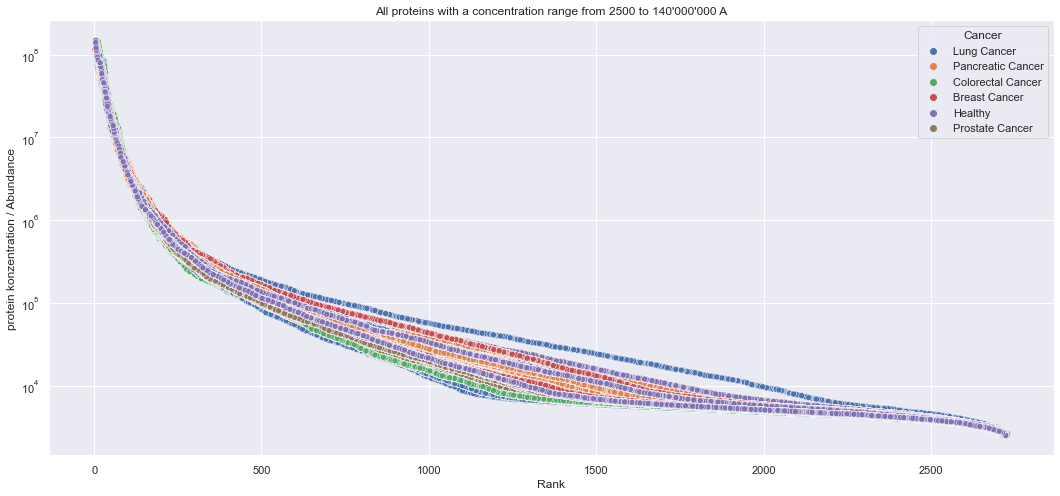

In [26]:
sns.set(rc={'figure.figsize':(18,8)})
_ = sns.scatterplot(x="Rank", y="meanAbu", hue="Cancer", data=tidySubFiltered)
_.set_yscale("log")
_.set_title("All proteins with a concentration range from 2500 to 140'000'000 A")
_.set_ylabel("protein konzentration / Abundance");

In [27]:
#reshape data for model
tidyReshaped = tidySubFiltered.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()

uniprot,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y696,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,2721.810303,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,21067.064453,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,3497.142578,6626.406738,100954.500000,1.029116e+06,15354.227539,...,231849.765625,37423.011719,32570.783203,16396.248047,5583.424316,2844.958496,17626.980469,3184120.25,19085.271484,125766.781250
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,2902.563721,3281.517090,7488.952148,15695.381836,4.025498e+04,70995.250000,...,43056.816406,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,2919.001953,1.193392e+04,26160.638672,...,27962.792969,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,28075.748047,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938


In [28]:
#y condition
Group =  tidySubFiltered.drop(["uniprot", "meanAbu", "Rank"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

,R.FileName,Cancer
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,Lung Cancer
1,J_D201211_MDIA_P705_SExp01-BGSID-10_R01,Lung Cancer
2,J_D201211_MDIA_P705_SExp01-BGSID-100_R01,Pancreatic Cancer
3,J_D201211_MDIA_P705_SExp01-BGSID-101_R01,Colorectal Cancer
4,J_D201211_MDIA_P705_SExp01-BGSID-102_R01,Lung Cancer


In [29]:
#merge X and y and set dataframe to numerical values
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")
data = data.set_index("R.FileName")

In [30]:
X_ = data.iloc[:, :-1].apply(np.log2)
y_ = data.iloc[:,-1]

#check head of the dataframe 
data.head()

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,2721.810303,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,3497.142578,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,2844.958496,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,2902.563721,3281.517090,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,2919.001953,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer


### Inputation

Due to the cutoff we end up with some proteins not having a value (NaN). Therefore the missing values need to be inputed.
To reduce the effect of outliers the median instead of the mean was used.

In [31]:
#Make pipeline and use median for NaN Values
dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X_)
X_.shape

(181, 2730)

### Encoding
Encode the different cancer types into numbers

In [32]:
# Encode target labels
labEnc = preprocessing.LabelEncoder() 
y = labEnc.fit_transform(y_) 

#show the encoding dictionair
cancerDict = dict(set(zip(y, y_)))
cancerTypes = list(cancerDict.items())
cancerTypes.sort()
print(cancerTypes)
targets = list(list(zip(*cancerTypes))[1])

[(0, 'Breast Cancer'), (1, 'Colorectal Cancer'), (2, 'Healthy'), (3, 'Lung Cancer'), (4, 'Pancreatic Cancer'), (5, 'Prostate Cancer')]


In [33]:
# Save X and y for next session
#joblib.dump(y, "Models2/y.pkl")
#joblib.dump(X, "Models2/X.pkl")


['Models2/X.pkl']

In [142]:
# load saved X and y 
#y = joblib.load("Models2/y.pkl")
#X = joblib.load("Models2/X.pkl")

(181, 2700)

## Part 4: Feature Selection
For the feature selection different appraoches are applied and the results of the feature selection will be visualized. 

Random Forest and XGBoost is applied for feature selection. 

Furthermore both approaches are conducted once with the scklearn.feature_selection and with sklearn.genetic.GAFeatureSelection
from which only the 100 proteins / biomarkers with the highest relevance are used.

### Random Forest Feature Selection:
* **sklearn.selectFromModel**

Original X shape: (181, 2730)
Feature selected X_new shape: (181, 100)


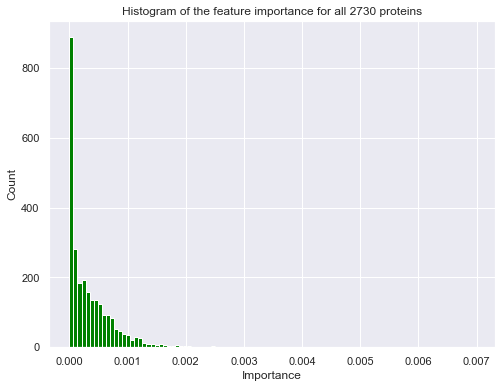

In [34]:
#create Random Forest classifier with random hyperparameters
params = {}
clf_RA  = RandomForestClassifier(random_state=0, **params)
clf_RA.fit(X, y)

#checkout importance in a histogram
plt.figure(figsize=(8,6))
plt.hist(clf_RA.feature_importances_, bins=100, color='green')
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")


#get the reduced X
selector  = SelectFromModel(estimator = clf_RA, prefit=True
                            , max_features=100
                            )
X_RF      = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_RF.shape}")

#joblib.dump(X_RF, "Models2/X_RF.pkl")
#joblib.dump(selector.get_support(), "Models2/featSel_RF.pkl")


In [49]:
y[:10]

array([4, 1, 3, 4, 0, 2, 4, 3, 1, 2])

### Random Forest Feature Selection:
* **sklearn-genetic-opt.GAFeatureSelectionCV**

In [53]:
#sklearn_genetic.GAFeatureSelection

params  = {}
clf_RF    = RandomForestClassifier(random_state=0, **params)

evolved_estimator = GAFeatureSelectionCV(
    estimator   = clf_RF,
    cv          = 5,
    population_size=20, 
    generations =40,
    crossover_probability=0.8,
    mutation_probability = 0.075,
    n_jobs      = -1,
    scoring     = "accuracy"
    ,max_features = 500
    )

# Train and select the features
evolved_estimator.fit(X, y)

# Features selected by the algorithm
X_RFGA    = X[:, evolved_estimator.best_features_]

#joblib.dump(X_RFGA, "Models2/X_RFGA.pkl")
#joblib.dump(evolved_estimator.best_features_, "Models2/featSel_RFGA.pkl")


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	20    	-10000 	0          	-10000     	-10000     
2  	35    	-10000 	0          	-10000     	-10000     

sklearn-genetic-opt closed prematurely. Will use the current best model.
INFO: Stopping the algorithm


### XGboost Feature Selection:
* **sklearn.selectFromModel**

C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Original X shape: (162, 2730)
Feature selected X_new shape: (162, 90)


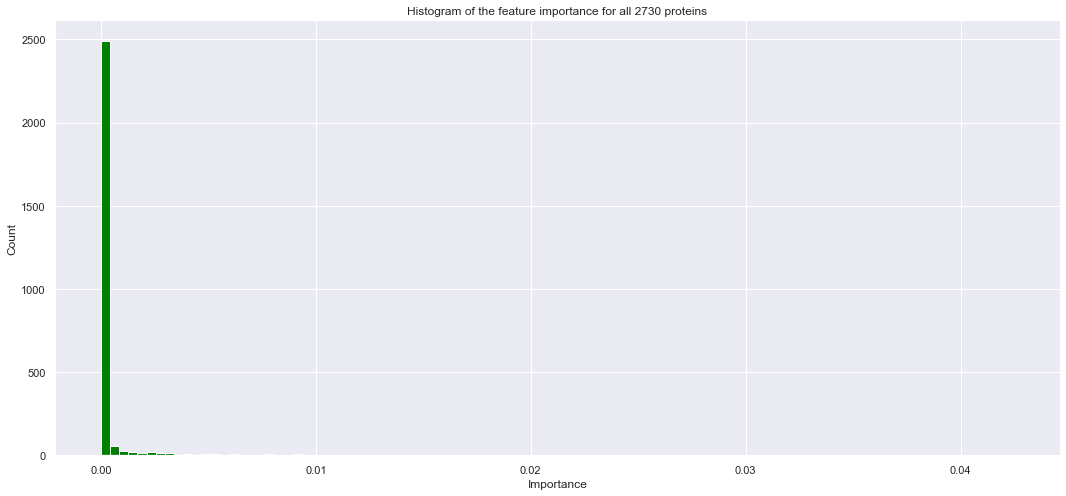

In [111]:
#sklearn.feature_selection
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            random_state=0)
clf_XG.fit(X,y)

#checkout importance in a histogram
plt.hist(clf_XG.feature_importances_, bins=100, color='green')
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

selector = SelectFromModel(estimator = clf_XG, max_features=90)
selector.fit(X,y)

X_XG = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_XG.shape}")

#joblib.dump(X_XG, "Models2/X_XG.pkl")
#joblib.dump(selector.get_support(), "Models2/featSel_XG.pkl")

In [ ]:
#sklearn_gentic.GAFeatureSelection
clf_XGGA = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_label_encoder=False,
                            random_state=0)
clf_XGGA.fit(X,y)

evolved_estimator = GAFeatureSelectionCV(
    estimator           = clf_XGGA,
    cv                  = 5,
    population_size     =25, 
    generations         =40,
    crossover_probability=0.8,
    mutation_probability= 0.1,
    n_jobs              = -1,
    scoring             = "accuracy",
    max_features        = 300)

# Train and select the features
evolved_estimator.fit(X, y)

#susbet data to only the chosen features
X_XGGA    = X[:, evolved_estimator.best_features_]

#joblib.dump(X_XGGA, "Models2/X_XGGA.pkl")
#joblib.dump(evolved_estimator.best_features_, "Models2/featSel_XGGA.pkl")


## Part 5: Model Training

#### To check which selected features from part 4 gives the best result, the Random Forest and XGboost is tested individually with each pool of selected features. 
#### The fifth feature selection will be the filtered proteins from part 2 with a p-value < 0.05 and a fold change > 2.0.


Both models run with the features of the klearn_featureselection, hence the feature selection of this module outperformed the sklearn.genetic.GAFeatureSelection.

### Results
As can be seen, the best performance with:
* Accuracy Random Forest: 0.763
* Accuracy XGBoost : 0.545
##### was achieved by using the **Random forest Model with the sklearn.selectFromModel module**

In [43]:
# Load the selected features 
featSel_part2   = X_.columns.isin(protSel)
featSel_RF      = joblib.load("Models2/featSel_RF.pkl")
featSel_RFGA    = joblib.load("Models2/featSel_RFGA.pkl")   
featSel_XG      = joblib.load("Models2/featSel_XG.pkl")
featSel_XGGA    = joblib.load("Models2/featSel_XGGA.pkl")

#cancer dict
#cancerTypes     = joblib.load("rawData/cancerTypes.pkl")

In [44]:
X[:,featSel_RFGA].shape

(181, 1208)

In [45]:
for featSel, featSelName in zip([featSel_part2,featSel_RF, featSel_RFGA, featSel_XG, featSel_XGGA], ["featSel_part2","featSel_RF", "featSel_RFGA", "featSel_XG", "featSel_XGGA"]):

    print("-----------------------------------")
    print("Feature Selection Method: \n")
    print(featSelName)
    print("-----------------------------------")
    #split the data

    X_train, X_val, y_train, y_val = train_test_split(X[:,featSel], y, test_size=0.3, random_state=11) #RANDOM STATE 11 IMPORTANT FOR BALANCED DATASETS

    #   ----------------------------------------------------------
    
    #initialize Random Forest
    clf_RF = RandomForestClassifier(random_state=0)
    clf_RF.fit(X_train ,y_train)
    y_RFpred = clf_RF.predict(X_val)

    print("Accuracy Random Forest:",metrics.accuracy_score(y_val , y_RFpred))
    print(classification_report(y_val, y_RFpred, target_names=targets))

#   ----------------------------------------------------------

    #initialize XGBoost
    clf_XG = xgboost.XGBClassifier(tree_method='exact',
                                eval_metric='mlogloss',
                                random_state=0)

    clf_XG.fit(X_train ,y_train)
    y_XGpred = clf_XG.predict(X_val)

    print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_val , y_XGpred))
    print(classification_report(y_val, y_XGpred, target_names=targets))


-----------------------------------
Feature Selection Method: 

featSel_part2
-----------------------------------
Accuracy Random Forest: 0.45454545454545453
                   precision    recall  f1-score   support

    Breast Cancer       0.33      0.38      0.35         8
Colorectal Cancer       0.33      0.30      0.32        10
          Healthy       0.57      0.40      0.47        10
      Lung Cancer       0.33      0.20      0.25        10
Pancreatic Cancer       0.64      0.78      0.70         9
  Prostate Cancer       0.46      0.75      0.57         8

         accuracy                           0.45        55
        macro avg       0.44      0.47      0.44        55
     weighted avg       0.44      0.45      0.44        55



C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Accuracy XGBoost Random Forest: 0.45454545454545453
                   precision    recall  f1-score   support

    Breast Cancer       0.14      0.25      0.18         8
Colorectal Cancer       0.60      0.30      0.40        10
          Healthy       0.57      0.40      0.47        10
      Lung Cancer       0.40      0.20      0.27        10
Pancreatic Cancer       0.53      0.89      0.67         9
  Prostate Cancer       0.67      0.75      0.71         8

         accuracy                           0.45        55
        macro avg       0.49      0.46      0.45        55
     weighted avg       0.49      0.45      0.44        55

-----------------------------------
Feature Selection Method: 

featSel_RF
-----------------------------------
Accuracy Random Forest: 0.5272727272727272
                   precision    recall  f1-score   support

    Breast Cancer       0.33      0.50      0.40         8
Colorectal Cancer       0.40      0.40      0.40        10
          Healthy      

C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Accuracy XGBoost Random Forest: 0.509090909090909
                   precision    recall  f1-score   support

    Breast Cancer       0.25      0.38      0.30         8
Colorectal Cancer       0.50      0.20      0.29        10
          Healthy       0.42      0.50      0.45        10
      Lung Cancer       0.67      0.40      0.50        10
Pancreatic Cancer       0.75      1.00      0.86         9
  Prostate Cancer       0.56      0.62      0.59         8

         accuracy                           0.51        55
        macro avg       0.52      0.52      0.50        55
     weighted avg       0.53      0.51      0.49        55

-----------------------------------
Feature Selection Method: 

featSel_RFGA
-----------------------------------
Accuracy Random Forest: 0.43636363636363634
                   precision    recall  f1-score   support

    Breast Cancer       0.17      0.25      0.20         8
Colorectal Cancer       0.71      0.50      0.59        10
          Healthy     

C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Accuracy XGBoost Random Forest: 0.41818181818181815
                   precision    recall  f1-score   support

    Breast Cancer       0.23      0.38      0.29         8
Colorectal Cancer       0.50      0.30      0.37        10
          Healthy       0.56      0.50      0.53        10
      Lung Cancer       0.40      0.20      0.27        10
Pancreatic Cancer       0.50      0.67      0.57         9
  Prostate Cancer       0.40      0.50      0.44         8

         accuracy                           0.42        55
        macro avg       0.43      0.42      0.41        55
     weighted avg       0.44      0.42      0.41        55

-----------------------------------
Feature Selection Method: 

featSel_XG
-----------------------------------
Accuracy Random Forest: 0.5272727272727272
                   precision    recall  f1-score   support

    Breast Cancer       0.33      0.62      0.43         8
Colorectal Cancer       0.50      0.50      0.50        10
          Healthy      

C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Accuracy XGBoost Random Forest: 0.6545454545454545
                   precision    recall  f1-score   support

    Breast Cancer       0.55      0.75      0.63         8
Colorectal Cancer       0.75      0.60      0.67        10
          Healthy       0.55      0.60      0.57        10
      Lung Cancer       1.00      0.40      0.57        10
Pancreatic Cancer       0.58      0.78      0.67         9
  Prostate Cancer       0.78      0.88      0.82         8

         accuracy                           0.65        55
        macro avg       0.70      0.67      0.66        55
     weighted avg       0.71      0.65      0.65        55

-----------------------------------
Feature Selection Method: 

featSel_XGGA
-----------------------------------
Accuracy Random Forest: 0.36363636363636365
                   precision    recall  f1-score   support

    Breast Cancer       0.18      0.38      0.24         8
Colorectal Cancer       0.29      0.20      0.24        10
          Healthy    

C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Accuracy XGBoost Random Forest: 0.41818181818181815
                   precision    recall  f1-score   support

    Breast Cancer       0.31      0.50      0.38         8
Colorectal Cancer       0.40      0.20      0.27        10
          Healthy       0.57      0.40      0.47        10
      Lung Cancer       0.67      0.20      0.31        10
Pancreatic Cancer       0.43      0.67      0.52         9
  Prostate Cancer       0.38      0.62      0.48         8

         accuracy                           0.42        55
        macro avg       0.46      0.43      0.40        55
     weighted avg       0.47      0.42      0.40        55



### Result Feature selection:
As can be seen the highest accuracy for both the Random forest classifier and the XGBoost classifier are observerd with the features from 
the sklearn.selectFromModel for XGboost with 
* Random forest acc = 0.527
* XGBoost acc = 0.624 

### Remove 10 % of the data for the test set

In [54]:
#split the data
X = dataPrepPipe.fit_transform(X_)
y = labEnc.fit_transform(y_) 
print('The original dataset with', X.shape[0], 'items is now split into:')
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=49) #RANDOM STATE = 49 FOR BALANCED CLASS OCCURENCE
txt1 ='X with {} items'.format(X.shape[0])
txt2 = 'X_test with {} items'.format(X_test.shape[0])
print(txt1)
print(txt2)

unique, counts = np.unique(y_test, return_counts=True)
print(f"random state {49}", dict(zip(targets, counts)))

The original dataset with 181 items is now split into:
X with 162 items
X_test with 19 items
random state 49 {'Breast Cancer': 3, 'Colorectal Cancer': 3, 'Healthy': 3, 'Lung Cancer': 3, 'Pancreatic Cancer': 3, 'Prostate Cancer': 4}


### With the 90% do another split for the train and validation set

In [55]:
#split the data
print('The original dataset with', X.shape[0], 'items is now split into:')
X_train, X_val, y_train, y_val = train_test_split(X[:,featSel_XG], y, test_size=0.2, random_state=11)
print(X.shape)
print(X_train.shape)
txt1 ='X_train with {} items'.format(X_train.shape[0])
txt2 = 'X_val with {} items'.format(X_val.shape[0])
print(txt1)
print(txt2)

unique, counts = np.unique(y_val, return_counts=True)
print(f"random state {49}", dict(zip(targets, counts)))

The original dataset with 162 items is now split into:
(162, 2730)
(129, 90)
X_train with 129 items
X_val with 33 items
random state 49 {'Breast Cancer': 7, 'Colorectal Cancer': 4, 'Healthy': 5, 'Lung Cancer': 5, 'Pancreatic Cancer': 7, 'Prostate Cancer': 5}


## Part 6: Hyperparameter Tuning
In this chapter the model is optimized by hyperparameter tuning. A random grid search is applied to selected hyperparameters of both models followed by a grid search to narrow down 
the search space

The hyperparametertuning follows the instructions of the following publication https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (31.12.21). 

Hyperparameter tuning needs time and resources. Therefore, after each hyperparameter tuning the model is run with optimized parameters, so hyperparameter tuning is not needed to be run if there is no time for it. 

Furthermore, be aware that each grid search results in different optimized parameters. We selected the best parameter we obtained by running the grid search several times with different conditions.

In [59]:
#TIME: 6 mins
#initialize model
clf_RF    = RandomForestClassifier(random_state=0)

#Define hyperparameters for tuning
n_estimators_RF = [x for x in np.linspace(start=100, stop=1000, dtype=int)] #number of trees
criterion_RF    = ['gini', 'entropy'] #function to measure quality of a split
max_depth_RF = [int(x) for x in np.arange(1, 100)] #numbber of levels
max_depth_RF.append(None)
min_samples_split_RF = [int(x) for x in np.arange(2, 30)] #minimum number of samples required to split a note
min_samples_leaf_RF = [np.arange(start=1, stop=5)] #minimum number of samples required at each leaf node
max_features_RF = ['auto', 'sqrt', 'log2'] #number of features
bootstrap_RF = [True, False] #method of selecting samples for training

#initialize random grid with hyperparameters
random_grid_RF = {'n_estimators': n_estimators_RF,
            'criterion'         : criterion_RF,
            'max_features'      : max_features_RF,
            'max_depth'         : max_depth_RF,                        
            'min_samples_split' : min_samples_split_RF,
            'bootstrap'         : bootstrap_RF}

#define model parameters for random grid search
RF_random = RandomizedSearchCV(estimator=clf_RF,
                            param_distributions=random_grid_RF,
                            n_iter=500,
                            cv=7,
                            verbose=2,
                            n_jobs=-1)

#fit the random search model
RF_random.fit(X_train, y_train)

#get best hyperparameters from the model
RF_random.best_params_

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


{'n_estimators': 430,
 'min_samples_split': 4,
 'max_features': 'log2',
 'max_depth': 70,
 'criterion': 'gini',
 'bootstrap': False}

In [60]:
params = {'n_estimators': 430,
 'min_samples_split': 4,
 'max_features': 'log2',
 'max_depth': 70,
 'criterion': 'gini',
 'bootstrap': False}

array([300, 320, 340, 360, 380, 400])

In [66]:
#TIME 15 min
#initialize model
clf_RF_tuned = RandomForestClassifier(random_state = 0)
clf_RF_tuned.fit(X_train ,y_train)

#Define hyperparameter ranges for gridsearch
n_estimators= [x for x in np.arange(410, 450, step=5)]
min_samples_split= [x for x in np.arange(1, 10, step = 1)]
max_features= ['auto', 'sqrt', 'log2']
max_depth = [x for x in np.arange(60, 80, step = 5)]
criterion= ['gini']
bootstrap = ['True', 'False']

grid_RF = {  'n_estimators': n_estimators,
                    'min_samples_split': min_samples_split,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'criterion': criterion,
                    'bootstrap': bootstrap
                    }


#define model parameters for grid search
RF_grid = GridSearchCV(estimator = clf_RF_tuned,
                        param_grid =grid_RF,
                        cv=7,
                        verbose=2,
                        n_jobs=-1)

#fit the grid search model
RF_grid.fit(X_train, y_train)

#get best hyperparameters from the model
RF_grid.best_params_

Fitting 7 folds for each of 1728 candidates, totalling 12096 fits


C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


1344 fits failed out of a total of 12096.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1344 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\cyan\Anaconda3\envs\ip821_R_python\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self

{'bootstrap': 'False',
 'criterion': 'gini',
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 420}

In [112]:
#run model with optimized hyperparameters

#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}

params = {'bootstrap': 'False',
 'criterion': 'gini',
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 420}

#initiate classifier for validation
clf_RF       = RandomForestClassifier(random_state=0)
clf_RF_tuned = RandomForestClassifier(**params, random_state=0)

clf_RF.fit(X_train ,y_train)
clf_RF_tuned.fit(X_train ,y_train)
y_RFpred_tuned = clf_RF_tuned.predict(X_val)

print("Accuracy Random Forest with tuned hyperparameters:",metrics.accuracy_score(y_val , y_RFpred_tuned))
print(classification_report(y_val, y_RFpred_tuned, target_names=targets))

Accuracy Random Forest with tuned hyperparameters: 0.6363636363636364
                   precision    recall  f1-score   support

    Breast Cancer       0.75      0.43      0.55         7
Colorectal Cancer       0.50      0.75      0.60         4
          Healthy       0.71      1.00      0.83         5
      Lung Cancer       0.75      0.60      0.67         5
Pancreatic Cancer       0.60      0.43      0.50         7
  Prostate Cancer       0.57      0.80      0.67         5

         accuracy                           0.64        33
        macro avg       0.65      0.67      0.64        33
     weighted avg       0.66      0.64      0.62        33



In [79]:
#TIME 8 min
#initialize model
clf_XG = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = ['mlogloss'])

#Define hyperparameters for tuning
alpha_XGRF = [x for x in np.linspace(start=0, stop=10, num=11)] #regularization rate for weights on the leafs
lambda_XGRF = [x for x in np.linspace(start=1, stop=10, num=100)] #regularization rate for weights on the leafs
gamma_XGRF = [x for x in np.linspace(start=0, stop=20, num=100)] #complexity control
eta_XGRF = [x for x in np.linspace(start=0, stop=1, num=10)] #learing rate
max_depth_XGRF = [x for x in np.arange(1, 10, step=1)] #number of levels
min_child_weight_XGRF = [x for x in np.linspace(start=0, stop=20, num=100)] #min sum of instant weight


random_grid_XGRF = {'alpha' : alpha_XGRF,
                    'lambda' : lambda_XGRF,
                    'gamma' : gamma_XGRF,
                    'eta' : eta_XGRF,
                    'max_depth' : max_depth_XGRF,
                    'min_child_weight' : min_child_weight_XGRF}


#define model parameters for random grid search
XGRF_random = RandomizedSearchCV(estimator=clf_XG,
                            param_distributions=random_grid_XGRF,
                            n_iter=500,
                            cv=7,
                            verbose=2,
                            n_jobs=-1)

#fit the random search model
XGRF_random.fit(X_train, y_train)

#get best hyperparameters from the model
XGRF_random.best_params_

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


{'min_child_weight': 0.0,
 'max_depth': 2,
 'lambda': 9.272727272727273,
 'gamma': 2.0202020202020203,
 'eta': 0.4444444444444444,
 'alpha': 0.0}

In [99]:
#TIME: 
#initialize model
clf_XG_tuned = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = ['mlogloss'], random_state=0)

#Define hyperparameters for tuning
alpha_XGRF = [x for x in np.arange(start=0, stop=3)] #regularization rate for weights on the leafs
lambda_XGRF = [x for x in np.linspace(start=7, stop=13, num=10)] #regularization rate for weights on the leafs
gamma_XGRF = [x for x in np.linspace(start=0, stop=5, num=10)] #complexity control
eta_XGRF = [x for x in np.linspace(start=0.3, stop=0.6, num=10)] #learing rate
max_depth_XGRF = [x for x in np.arange(1, 3, step=1)] #number of levels
min_child_weight_XGRF = [x for x in np.linspace(start=0, stop=2, num=10)] #min sum of instant weight


random_grid_XGRF = {'alpha' : alpha_XGRF,
                    'lambda' : lambda_XGRF,
                    'gamma' : gamma_XGRF,
                    'eta' : eta_XGRF,
                    'max_depth' : max_depth_XGRF,
                    'min_child_weight' : min_child_weight_XGRF}


#define model parameters for random grid search
XG_grid = GridSearchCV(estimator = clf_RF_tuned,
                        param_grid = random_grid_XGRF,
                        cv=7,
                        verbose=2,
                        n_jobs=-1)

#fit the random search model
XGRF_random.fit(X_train, y_train)

#get best hyperparameters from the model
XGRF_random.best_params_

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


{'min_child_weight': 2.0202020202020203,
 'max_depth': 7,
 'lambda': 8.818181818181818,
 'gamma': 1.8181818181818181,
 'eta': 0.6666666666666666,
 'alpha': 0.0}

In [125]:
#run model with parameters from the gridSearch
params = {'min_child_weight': 2.0202020202020203,
 'max_depth': 7,
 'lambda': 8.818181818181818,
 'gamma': 1.8181818181818181,
 'eta': 0.6666666666666666,
 'alpha': 0.0}

#initiate classifier for validation
clf_XG = xgboost.XGBClassifier(     random_state=0,
                                     eval_metric = ['mlogloss'],
                                     use_label_encoder=False)
clf_XG_tuned = xgboost.XGBClassifier(**params,
                                     random_state=0,
                                     eval_metric = ['mlogloss'],
                                     use_label_encoder=False)

clf_XG.fit(X_train ,y_train)
clf_XG_tuned.fit(X_train ,y_train)

y_XGpred_tuned = clf_XG_tuned.predict(X_val)

print("Accuracy XGBoost with tuned hyperparameters:",metrics.accuracy_score(y_val , y_XGpred_tuned))
print(classification_report(y_val, y_XGpred_tuned, target_names=targets))

Accuracy XGBoost with tuned hyperparameters: 0.6666666666666666
                   precision    recall  f1-score   support

    Breast Cancer       0.80      0.57      0.67         7
Colorectal Cancer       0.75      0.75      0.75         4
          Healthy       0.56      1.00      0.71         5
      Lung Cancer       0.60      0.60      0.60         5
Pancreatic Cancer       0.60      0.43      0.50         7
  Prostate Cancer       0.80      0.80      0.80         5

         accuracy                           0.67        33
        macro avg       0.68      0.69      0.67        33
     weighted avg       0.68      0.67      0.66        33



## Part 7: Model Validation

To evaluate the model a confusion matrix for random forest aswell as xgboost is created. 

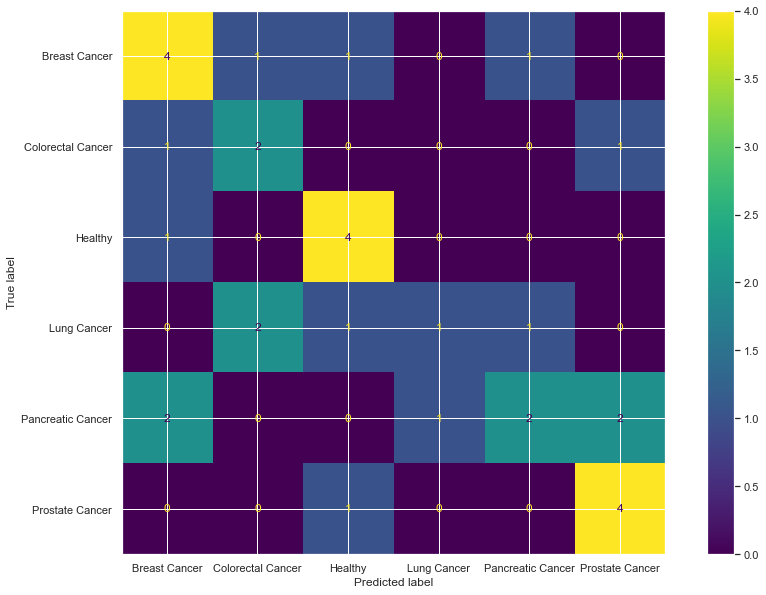

In [114]:
# visualize confusion matrix use same for X_test[:,featSel_XG] and y_test
y_val_RFpred =  clf_RF.predict(X_val)
cm = confusion_matrix(y_val, y_val_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=targets)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax);

The amount of false negatives is very low here.
Only one sample from our validation set which was pancreatic cancer has been wrongly predicted as healthy.

This means out false negative rate for this set is only 1/33 samples --> 3%

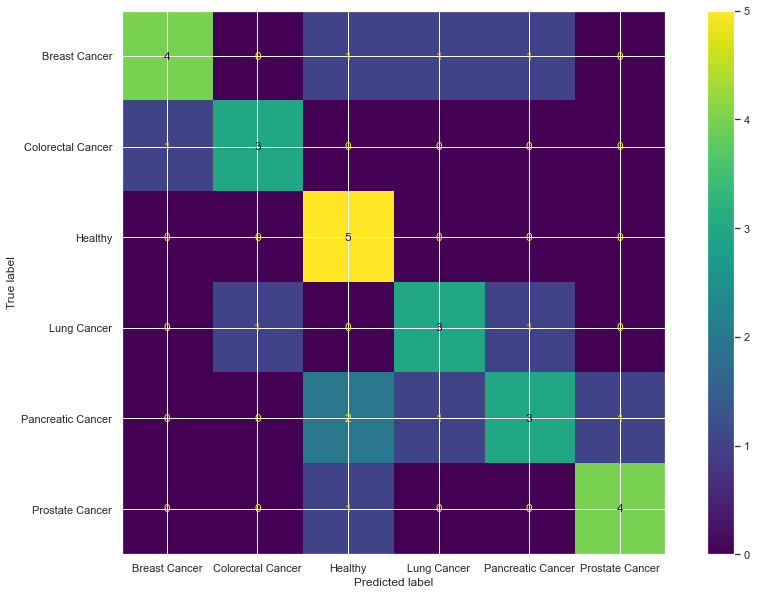

In [115]:
# visualize confusion matrix use same for X_test[:,featSel_RF] and y_test
y_val_XGpred =  clf_XG_tuned.predict(X_val)
cm = confusion_matrix(y_val, y_val_XGpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=targets)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax);

The false negative rate could even be improved by tuning our random forest classifier.

It now is 0% on our validation set.

This confusion matrix shows us that 

In [116]:
print('Random Forest Accuracy: ')
print(classification_report(y_test, clf_RF.predict(X_test[:,featSel_XG]), target_names=targets))
print('Tuned Random Forest Accuracy: ')
print(classification_report(y_test, clf_RF_tuned.predict(X_test[:,featSel_XG]), target_names=targets))

Random Forest Accuracy: 
                   precision    recall  f1-score   support

    Breast Cancer       0.50      0.67      0.57         3
Colorectal Cancer       1.00      0.33      0.50         3
          Healthy       0.67      0.67      0.67         3
      Lung Cancer       0.50      0.67      0.57         3
Pancreatic Cancer       1.00      1.00      1.00         3
  Prostate Cancer       0.75      0.75      0.75         4

         accuracy                           0.68        19
        macro avg       0.74      0.68      0.68        19
     weighted avg       0.74      0.68      0.68        19

Tuned Random Forest Accuracy: 
                   precision    recall  f1-score   support

    Breast Cancer       1.00      0.67      0.80         3
Colorectal Cancer       0.50      0.33      0.40         3
          Healthy       0.50      0.67      0.57         3
      Lung Cancer       0.67      0.67      0.67         3
Pancreatic Cancer       0.75      1.00      0.86       

In [126]:
print('XGBoost Accuracy: ')
print(classification_report(y_test, clf_XG.predict(X_test[:,featSel_XG]), target_names=targets))
print('Tuned XGBoost Accuracy: ')
print(classification_report(y_test, clf_XG_tuned.predict(X_test[:,featSel_XG]), target_names=targets))

XGBoost Accuracy: 
                   precision    recall  f1-score   support

    Breast Cancer       0.75      1.00      0.86         3
Colorectal Cancer       1.00      0.67      0.80         3
          Healthy       0.67      0.67      0.67         3
      Lung Cancer       0.67      0.67      0.67         3
Pancreatic Cancer       0.75      1.00      0.86         3
  Prostate Cancer       1.00      0.75      0.86         4

         accuracy                           0.79        19
        macro avg       0.81      0.79      0.78        19
     weighted avg       0.82      0.79      0.79        19

Tuned XGBoost Accuracy: 
                   precision    recall  f1-score   support

    Breast Cancer       0.40      0.67      0.50         3
Colorectal Cancer       0.33      0.33      0.33         3
          Healthy       1.00      0.67      0.80         3
      Lung Cancer       0.67      0.67      0.67         3
Pancreatic Cancer       0.75      1.00      0.86         3
  Prosta

### Comparing uncertainty of Data and Model

In [150]:
paramsEmpty = {}
params2 ={'bootstrap': 'False',
 'criterion': 'gini',
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 420}

for params, mes in zip([paramsEmpty, params2], ["no parameter", "With parameter"]):
    print("----- ", mes, "-------")
    clf_RF_unc = RandomForestClassifier(**params, random_state = 0)

    scores = cross_val_score(clf_RF_unc, X_train, y_train, cv=5, scoring='accuracy')
    Udata = scores.std()

    modAcuRF = []
    for rs in range(0, 5):
        clf_RF_val2 = RandomForestClassifier(**params, random_state = rs)
        clf_RF_val2.fit(X_train, y_train)
        modAcuRF += [accuracy_score(y_test, clf_RF_val2.predict(X_test[:, featSel_XG]))]

    Umodel = np.std(modAcuRF)

    print("Uncertainty in the data: %.3f" % Udata)
    print("Uncertainty in the model: %.3f" % Umodel)
    print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))


-----  no parameter -------
Uncertainty in the data: 0.059
Uncertainty in the model: 0.063
The model performance is 0.589 ± 0.059 ± 0.063
-----  With parameter -------
Uncertainty in the data: 0.051
Uncertainty in the model: 0.039
The model performance is 0.652 ± 0.051 ± 0.039


In [151]:
paramsEmpty = {}
params2 =   {'min_child_weight': 2.0202020202020203,
 'max_depth': 7,
 'lambda': 8.818181818181818,
 'gamma': 1.8181818181818181,
 'eta': 0.6666666666666666,
 'alpha': 0.0}

for params, mes in zip([paramsEmpty, params2], ["no parameter", "With parameter"]):
    print("----- ", mes, "-------")

    clf_XG_unc = xgboost.XGBClassifier(**params, eval_metric = ['mlogloss'], use_label_encoder=False)

    scores = cross_val_score(clf_XG_unc, X_train, y_train, cv=5, scoring='accuracy')
    Udata = scores.std()

    modAcuXGRF = []
    for rs in range(0,5):
        model = xgboost.XGBClassifier(random_state=rs, **params, eval_metric = ['mlogloss'], use_label_encoder=False)
        model.fit(X_train, y_train)
        modAcuXGRF += [accuracy_score(y_test, model.predict(X_test[:, featSel_XG]))]

    Umodel = np.std(modAcuXGRF)

    print("Uncertainty in the data: %.3f" % Udata)
    print("Uncertainty in the model: %.3f" % Umodel)
    print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

-----  no parameter -------
Uncertainty in the data: 0.052
Uncertainty in the model: 0.000
The model performance is 0.620 ± 0.052 ± 0.000
-----  With parameter -------
Uncertainty in the data: 0.071
Uncertainty in the model: 0.000
The model performance is 0.551 ± 0.071 ± 0.000


### Discussion and comparison of model uncertainty


Comparing the Random forest models (not-tuned and tuned) with the XGBoost models (not-tuned and tuned) we observe that the performance of the models

strongly depend on different factors like random state, hyperparameters etc. 

To summarize what we evaluated in tha validation part of the project:

Considering only the models with the same random state (=0) and the corresponding hyperparameters the best performance

on our test set with a very balanced class distribution! is:

* Random forest (acc: 0.68) > tuned Random forest (acc: 0.68)

With very similar recall an f1-score these models differ in the precision for which the normal Random forest outperformes the tuned version.

* XGBoost (acc: 0.79) > tuned XGBoost (acc: 0.63)

Although both Algorithm work the same way, the variaty of parameters have a strong influence on the performance. It can be observed that the 
not-tuned model outperformes the tuned level on all instances. With an accuracy 79% it shows the best results. Nevertheless the small test-size of 
10% should be considered while interpreting the results.

---

The uncertainty analysis with the random states 0 to 5 revealed a rather high uncertainty also caused by the small number of samples in the test set.

The folloing was observed:
* Random forest without parameters: 0.589 ± 0.059 ± 0.063
* Random forest with parameters:    0.652 ± 0.051 ± 0.039
* XGBoost without parameters:       0.620 ± 0.052 ± 0.000
* XGBoost with parameters:          0.551 ± 0.071 ± 0.000

The uncertainty from the model was only varying for the random forest ranging from 0.039 to 0.063 whereas XGBoost has (in this specific example) no model uncertainty.

On the other hand we see a similar distribution in the data ranging from 0.051 up to 0.071. This finding supports the problem of a low data number and should be considered 

for further analysis.  


### Receiver Operating Characteristic (ROC)

The visualize the learning process of the models with ROC curves the target classes had to be binarized with a following one vs rest classification. This method does not 

directly respresent our strategy but it enables a diognostic analysis of the model. This visualisation couldn't be produced for the XGBoost due to the missing possibility for 

an probability output when having a mulit-class problem

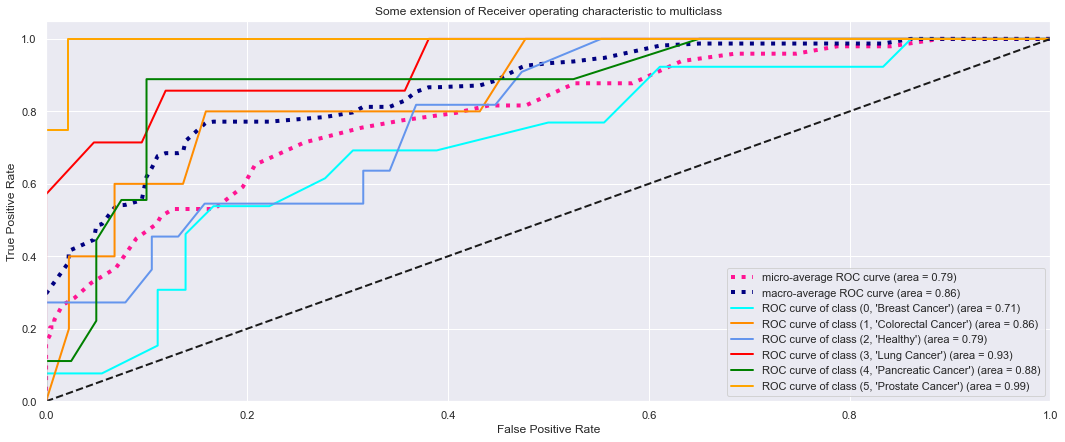

[20:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

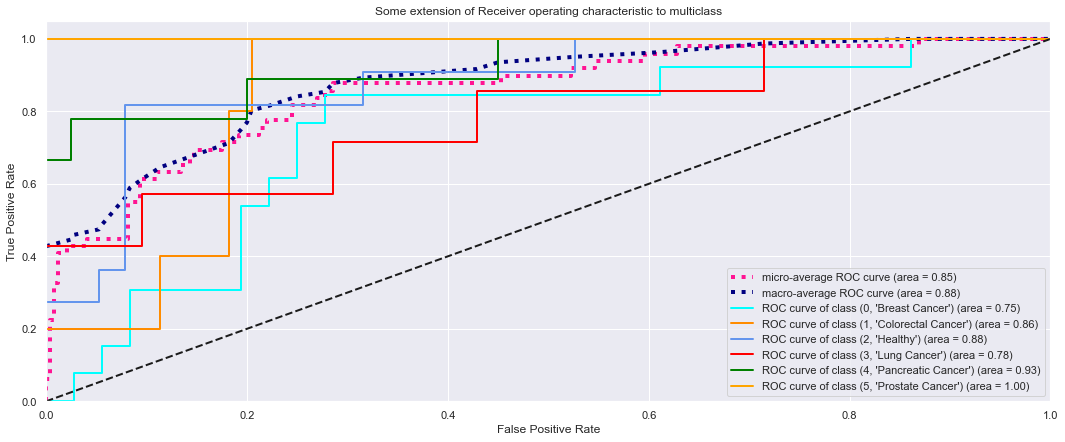

In [155]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

n_classes = 6

y_ROC = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])

# shuffle and split training and test sets
X_train, X_val, y_train, y_val = train_test_split(X[:,featSel_XG], y_ROC, test_size=0.3, random_state=0)

#params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}
params = {}
# Learn to predict each class against the other

for i in [RandomForestClassifier(random_state=0),  xgboost.XGBClassifier(random_state = 0, use_label_encoder=False)]:
    classifier = OneVsRestClassifier(
        i
    )
    y_score = classifier.fit(X_train, y_train).predict_proba(X_val)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    lw = 2

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(18,7))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "orange"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(cancerTypes[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

## Model explainability

### Using the package eli5

#### As can be seen from the first entry P05186 = Alkaline phosphatase this is a known biomarker for the following cancer: https://glygen.org/protein/P05186#
* colorectral cancer
* breast cancer
* lung cancer

#### or second entry Q01995 = Transgelin (https://research.bioinformatics.udel.edu/iptmnet/entry/Q01995/)
* lung cancer
* melanoma


In [71]:
clf_RF_tuned = RandomForestClassifier(**params, random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)

eli5.show_weights(clf_RF_tuned, feature_names=X_.iloc[:, featSel_RF].columns.tolist())


Weight,Feature
0.0355 ± 0.0992,P02787
0.0331 ± 0.0966,P07288
0.0300 ± 0.0853,P02144
0.0267 ± 0.0780,Q01995
0.0234 ± 0.0695,P20742
0.0219 ± 0.0751,P05186
0.0192 ± 0.0671,P18065
0.0168 ± 0.0568,P41159
0.0159 ± 0.0567,P15144
0.0150 ± 0.0670,Q01518


In [72]:
eli5.sklearn.explain_prediction_tree_classifier(estimator = clf_RF_tuned, 
                                                feature_names=X_.iloc[:, featSel_XG].columns.tolist())

AttributeError: module 'eli5.sklearn' has no attribute 'explain_prediction_tree_classifier'

Create visualisations of a tree from our models

In [257]:
classes = ['Breast Cancer', 'Colorectal Cancer', 'Healthy', 'Lung Cancer', 'Pancreatic Cancer', 'Prostate Cancer']

Random Forest Model:


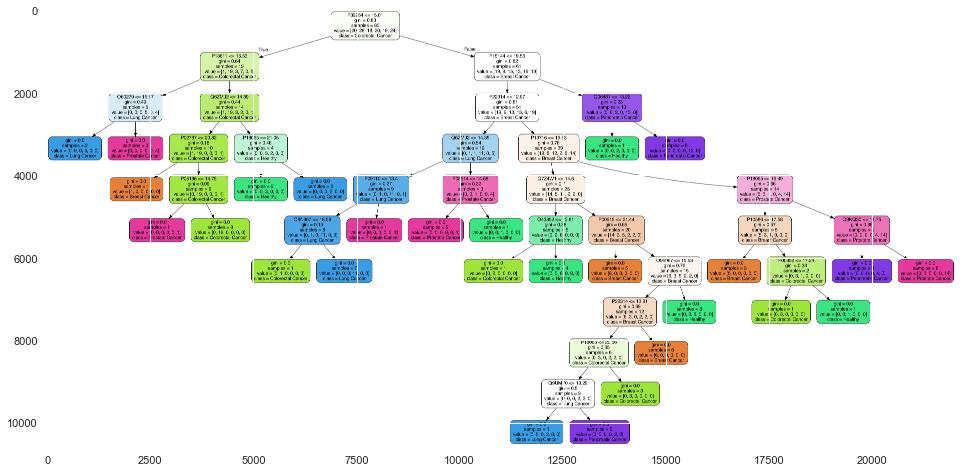

In [258]:
# Visualise a tree of the base model! 
estimator = clf_RF.estimators_[10]
# Export as dot file
export_graphviz(estimator, 
                out_file='./images/tree_RF.dot', 
                feature_names = X_.loc[:,featSel_RF].columns.tolist(),
                class_names = classes,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png
call(['dot', '-Tpng', './images/tree_RF.dot', '-o', './images/tree_RF.png', '-Gdpi=600'])
plt.imshow(plt.imread('./images/tree_RF.png'))
print('Random Forest Model:')
plt.show()

Tuned Random Forest Model: 


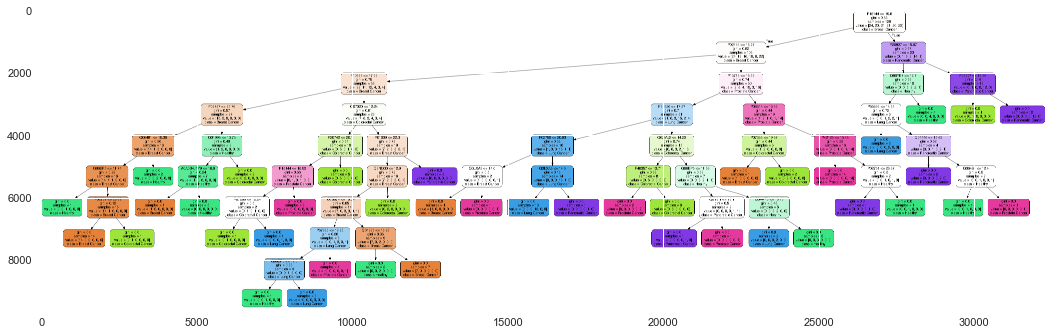

In [266]:
# Visualise single tree of the tuned random forest model
estimator = clf_RF_tuned.estimators_[10]
# Export as dot file
export_graphviz(estimator, 
                out_file='./images/tree_RF_tuned.dot', 
                feature_names = X_.loc[:,featSel_RF].columns.tolist(),
                class_names = classes,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png
call(['dot', '-Tpng', './images/tree_RF_tuned.dot', '-o', './images/tree_RF_tuned.png', '-Gdpi=600'])
plt.imshow(plt.imread('./images/tree_RF_tuned.png'))
print('Tuned Random Forest Model: ')
plt.show()

[10:03:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Base XGBoost visualisation:


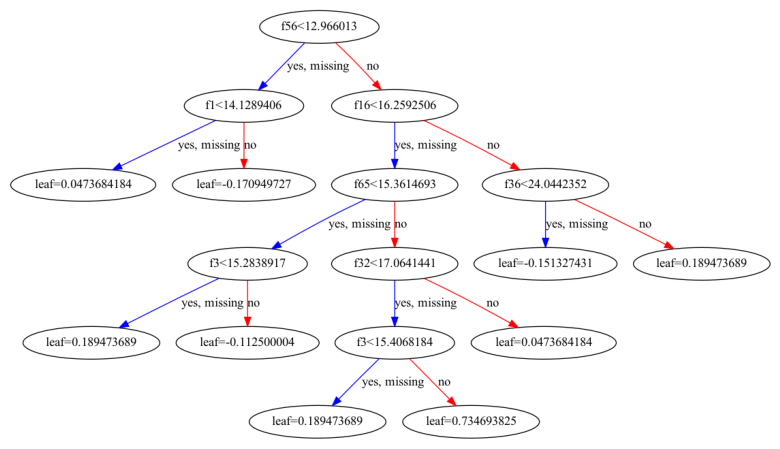

In [272]:
clf_XG = xgboost.XGBClassifier(random_state=0, use_label_encoder=False)
clf_XG.fit(X_train, y_train)
print('Base XGBoost visualisation:')
xgboost.plot_tree(clf_XG);

Tuned XGBoost visualisation:


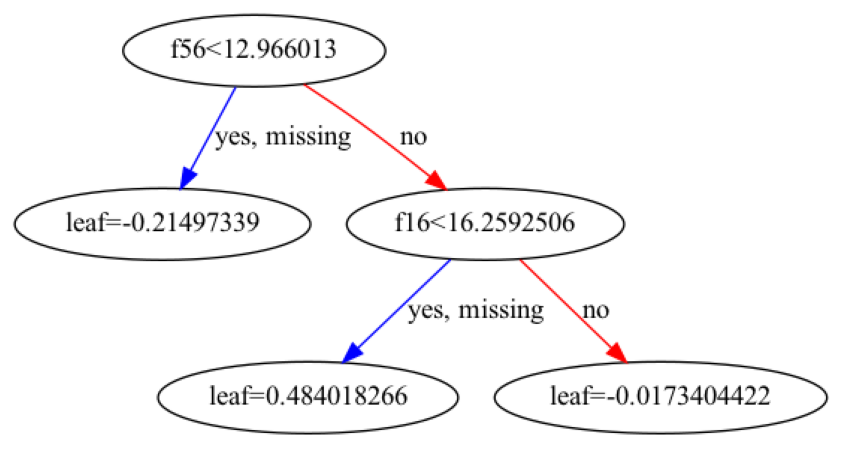

In [273]:
print('Tuned XGBoost visualisation:')
xgboost.plot_tree(clf_XG_tuned);

### Discussion and Outlook
The aim of this project work was to classify patient’s health status according to their corresponding protein fingerprints. As the code shows, two different classifiers (Random Forest and XGBoost) had been implemented successfully to predict a patient’s health status and cancer type with an accuracy over 60 %. This code shows the importance of feature selection. Two different approaches were implented. The genetic approach did not manage to conduct a suitable feature selection. There can be many reasons for the results. GA provide  numerous parameters which can be change to improove performance. To determine those parameters, a lot of times is needed. With further improvments of the parameters the GA probably will be a suitable tool to for feature selection and will achieve comparable results like the sklearn.feature_selection. In the future, further methods should be conducted to find the best features.  

A random grid search was applied to search for optimized hyperparameters. During the project work it was not possible to find optimized parameters. Even if the random grids search work, the proposed parameters did not result in an higher accuracy of both models. The accuracy was the same or lower as the default parameters. Meaning at this moment the default parameter of the random forest and XGBoost classifiers are the ones with the highest accuracy. This does not mean, that the random grid search is not suitable for hyperparameter tuning per se. Hyperparameter tuning is time and ressource intensive and during the project work no better parameters could be found.

After random grid search, we tried finding a local minimum near the found best parameters by applying a grid search within the parameters' range. However, this only improved the performance by a small amount.
Analysing the prediction results with our validation and test set, we saw that the false negative rate is very low (1/52 --> 2%) which is crucial for such prediction methods. If a cancer patients status is falsely predicted as healthy with a 2% chance, we can conclude that our model works quite well.

However, this does not mean that there are better parameters than the default ones (absence of evidence does not mean evidence of absence). For sure, more time and resources would need to be invested into the hyperparameter tuning. Furthermore, different approaches should also been tested. Additional investigations in hyperparameter tuning will probably make this code even more reliable which is needed for a possible real live implementation. Overall, this works shows that digital approaches can be beneficial in the determination of cancer diagnosis. Computer-based analysis have a major potential and with further improvements and adjustments of the code the usability will continuously improve. With the right settings, code like this will be a helpful tool for specialists to classify diseases and help finding effective treatments.